In [468]:
from covid_api import CovidAPI
from covid_api import APIHelper
from datetime import datetime
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import numpy as np

In [ ]:
#getting continents and countries

url = 'https://pkgstore.datahub.io/JohnSnowLabs/country-and-continent-codes-list/country-and-continent-codes-list-csv_csv/data/b7876b7f496677669644f3d1069d3121/country-and-continent-codes-list-csv_csv.csv'
data = pd.read_csv(url)
data.to_csv('country-and-continent-codes-list-csv_csv.csv')

new_df = pd.DataFrame(columns=['continent_code', 'country_code'])
new_df['continent_code'] = data.Continent_Code
new_df['country_code'] = data.Two_Letter_Country_Code
new_df = new_df.sort_values('continent_code')
old_size = new_df.size
new_df = new_df.dropna()
new_size = new_df.size
print(str(old_size - new_size) + ' items were removed because of NaN')

new_df[new_df.country_code == 'AF'].continent_code[0]

In [ ]:
all_countries = CovidAPI.get_task('/all')
deaths = all_countries['deaths']
confirmed = all_countries['confirmed']
recovered = all_countries['recovered']

In [347]:
def look_for(k, arr):
    for i in arr['locations']:
        if i['country_code'] == k:
            return i['history']
        
def look_for_continent(country_key):
    for i in range(0,len(new_df)):
        item = new_df.iloc[i]
        if item.country_code == country_key:
            return item.continent_code

In [348]:

columns = ['country_code', 'date', 'deaths', 'confirmed', 'recovered', 'continent_code']
df = pd.DataFrame(columns=columns)
i=0

c_deaths = None
i=0
for country_key, country_value in CovidAPI.get_countries().items():
    country_deaths = look_for(country_key, deaths)
    country_confirmed = look_for(country_key, confirmed)
    country_recovered = look_for(country_key, recovered)
    
    continent_code = look_for_continent(country_key)
    
    if country_deaths != None and country_confirmed != None and country_recovered != None:
        for date, death_amount in country_deaths.items():
            confirmed_amount = country_confirmed[date]
            recovered_amount = country_recovered[date]
            date = datetime.strptime(date, '%m/%d/%y')
            df.loc[i] = [country_key, date, death_amount, confirmed_amount, recovered_amount, continent_code]
            i=i+1


In [93]:
df = df.sort_values(['country_code', 'date'])
df.to_csv('all.csv')    

# grafico de barras con cantidad de muertos, confirmados recuperados (mundial y por continente) hacerlo todo en el mismo grafico ?? analizar/marcar picos - marcar fecha en que OMS declara pandemia.
 

In [423]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y %m')

plt.style.use('seaborn-whitegrid')
def covid_lineplot(covid_deaths, covid_confirmed, covid_recovered):
    fig, ax = plt.subplots()

    ax.plot(covid_deaths, color='black')
    ax.plot(covid_confirmed)
    ax.plot(covid_recovered)

    #ax.legend((l2, l4), ('oscillatory', 'damped'), loc='upper right', shadow=True)
    ax.legend(('oscillatory', 'damped', 'dsadad'),fontsize=15)

    # format the ticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)

    # round to nearest years.
    covid_recovered.index[-1]
    datemin = np.datetime64(covid_recovered.index[0], 'Y')
    datemax = np.datetime64(covid_recovered.index[-1], 'Y') + np.timedelta64(1, 'Y')
    ax.set_xlim(datemin, datemax)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    ax.grid(True)

    ax.set_title('Default Date Formatter',fontsize=15)
    ax.set_xlabel('common xlabel',fontsize=15)
    ax.set_ylabel('common ylabel',fontsize=15)
    #ax.set_yticks(np.arange(0, 50000000, 5000000))
    
    import datetime as dt
    plt.axvline(dt.datetime(2020, 3, 11),color='black',linestyle='--')
    x_text_annotation = dt.datetime(2020, 3, 11)
    #ax.text(x=x_text_annotation, y=40000000, s='WHO declared covid as pandemic', color='#334f8d',fontsize=15)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()

    fig.set_size_inches(15.5, 10.5)

    plt.show()


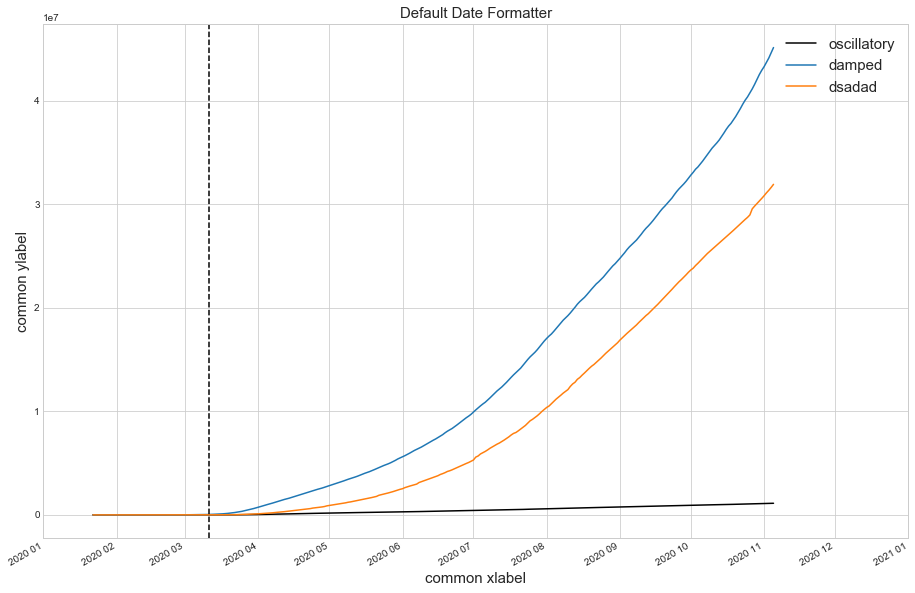

In [424]:
covid_by_date = df.groupby('date').sum()
covid_deaths = covid_by_date.deaths
covid_confirmed = covid_by_date.confirmed
covid_recovered = covid_by_date.recovered

covid_lineplot(covid_deaths, covid_confirmed, covid_recovered)

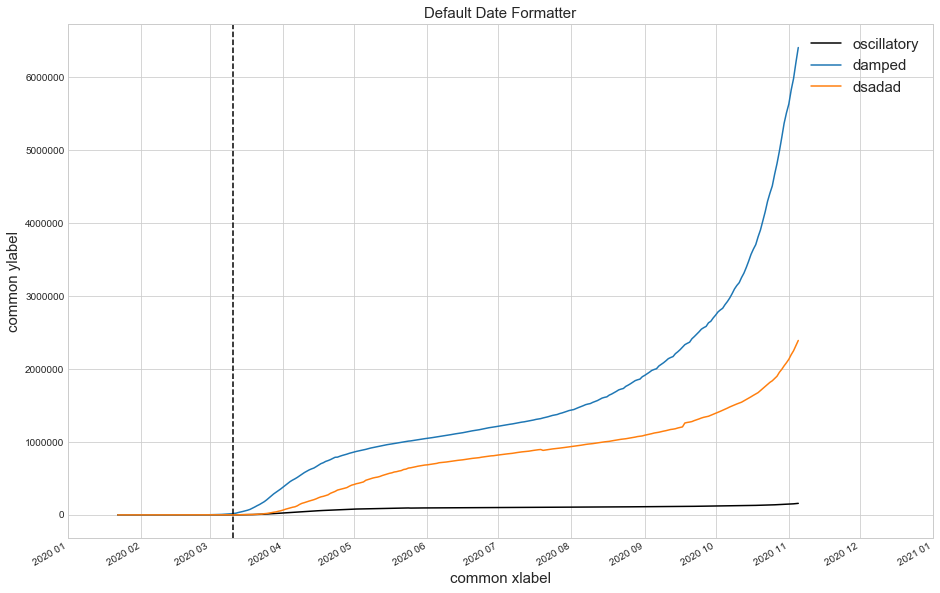

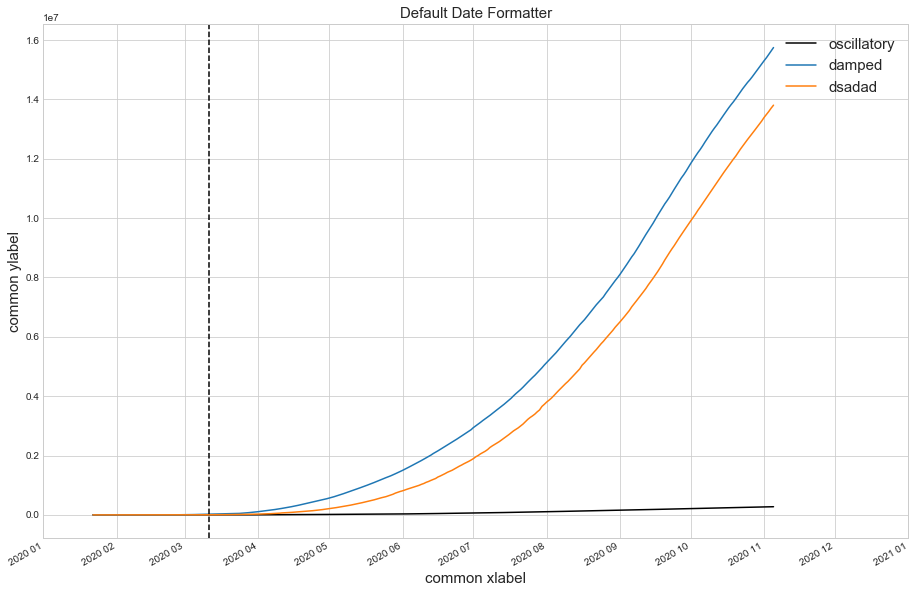

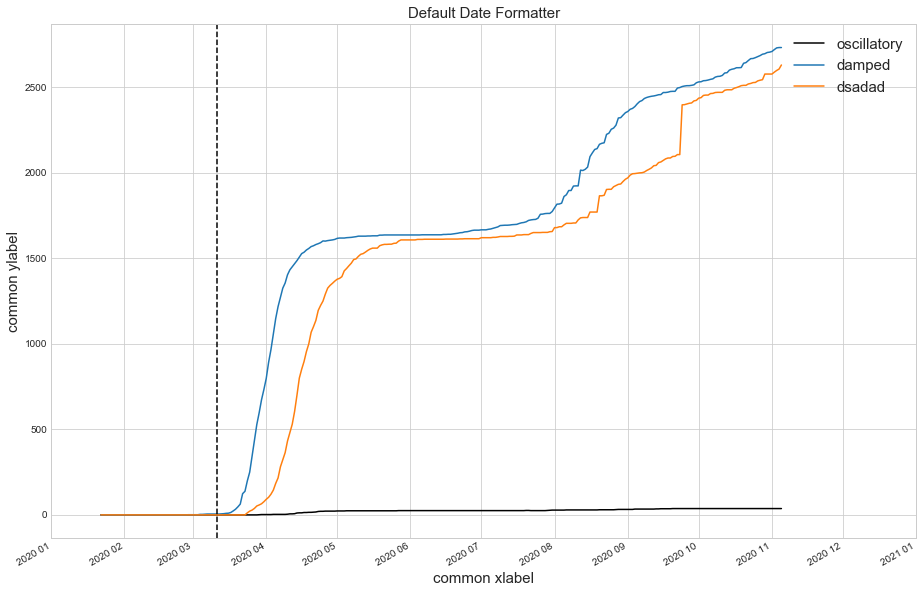

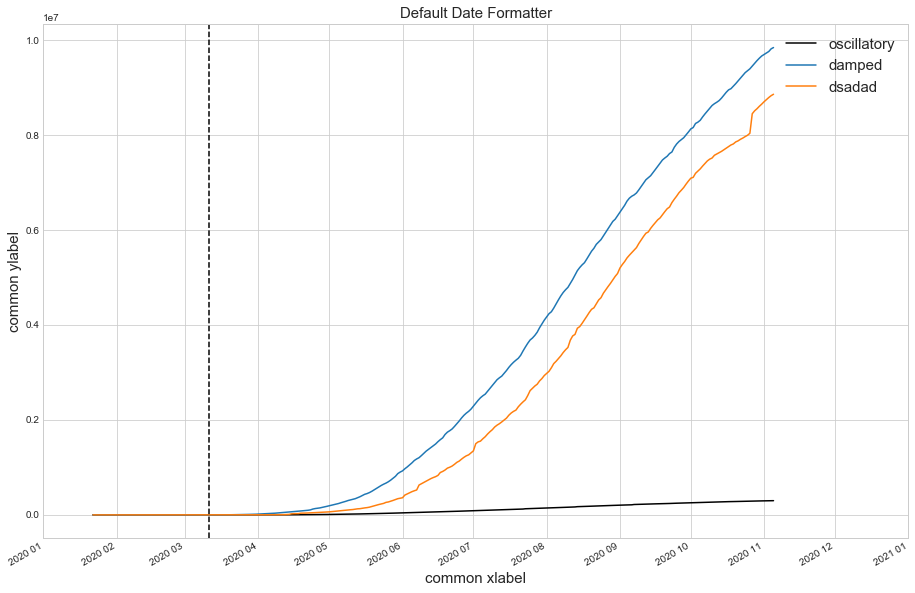

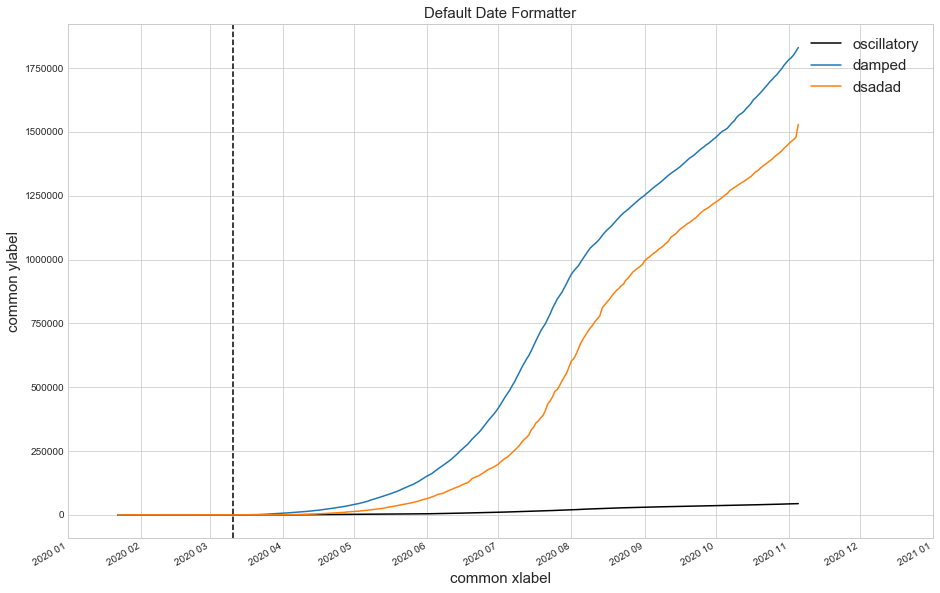

In [425]:
for c in list(set(df.continent_code.dropna())):
    df_c = df[df.continent_code == c]
    covid_by_date = df_c.groupby('date').sum()
    covid_deaths = covid_by_date.deaths
    covid_confirmed = covid_by_date.confirmed
    covid_recovered = covid_by_date.recovered
    
    covid_lineplot(covid_deaths, covid_confirmed, covid_recovered)

# top 10 pais con mayor cantidad de muertos, confirm, recup. (considerando v2/locations -> country_population) 

In [408]:
def calculate_percentage(current_population, country_population):
    try:
        precision = 5
        return round((current_population*100.0)/country_population, precision)
    except:
        return None
    

columns = ['country_code', 'deaths_percentage', 'confirmed_percentage', 'recovered_percentage', 'deaths', 'confirmed', 'recovered']
pd.options.display.float_format = '{:,.5f}'.format
df_p = pd.DataFrame(columns=columns)

i=0
c_resp = CovidAPI.get_task('/v2/locations', payload=payload)
    
for c_location in c_resp["locations"]:
    country_population = c_location['country_population']
    country_code = c_location['country_code']
    c_latest = c_location["latest"]        

    confirmed = c_latest['confirmed']
    recovered = c_latest['recovered']
    deaths = c_latest['deaths']
    
    confirmed_percentage = calculate_percentage(c_latest['confirmed'], country_population)
    recovered_percentage = calculate_percentage(c_latest['recovered'], country_population)
    deaths_percentage = calculate_percentage(c_latest['deaths'], country_population)
    df_p.loc[i] = [country_code, deaths_percentage, confirmed_percentage, recovered_percentage, deaths, confirmed, recovered]
    i=i+1
    

In [409]:
df_p_c = df_p.sort_values(['confirmed'], ascending=False)[:5]
df_p_d = df_p.sort_values(['deaths'], ascending=False)[:5]
df_p_r = df_p.sort_values(['recovered'], ascending=False)[:5]

In [441]:
df_p_c = df_p.sort_values(['confirmed_percentage'], ascending=False)[:5]
df_p_d = df_p.sort_values(['deaths_percentage'], ascending=False)[:5]
df_p_r = df_p.sort_values(['recovered_percentage'], ascending=False)[:5]

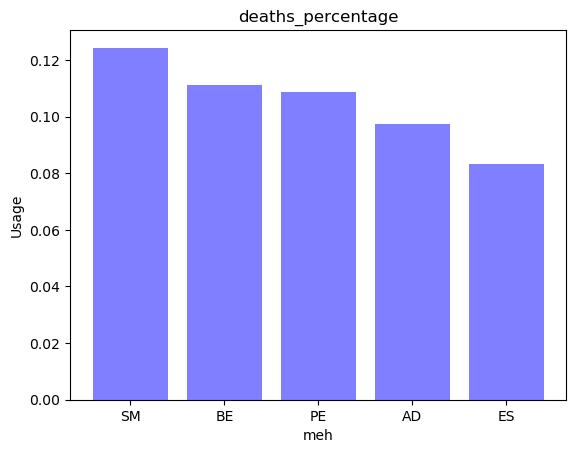

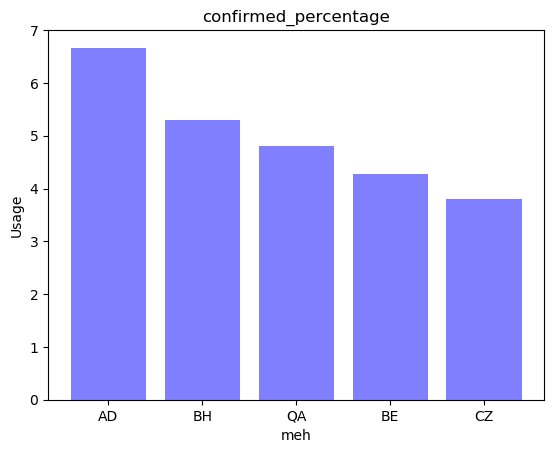

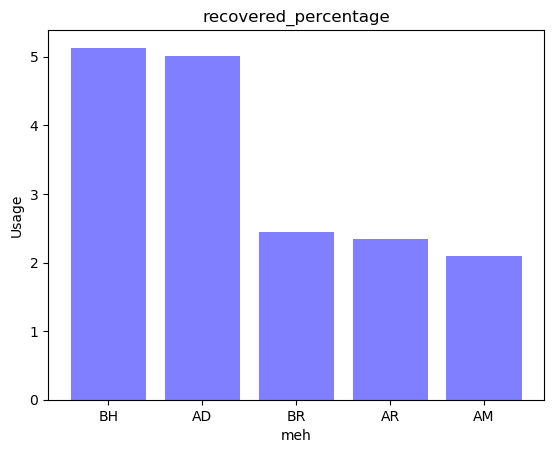

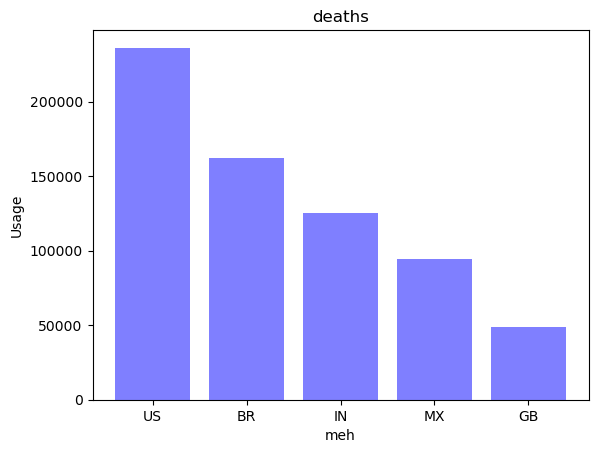

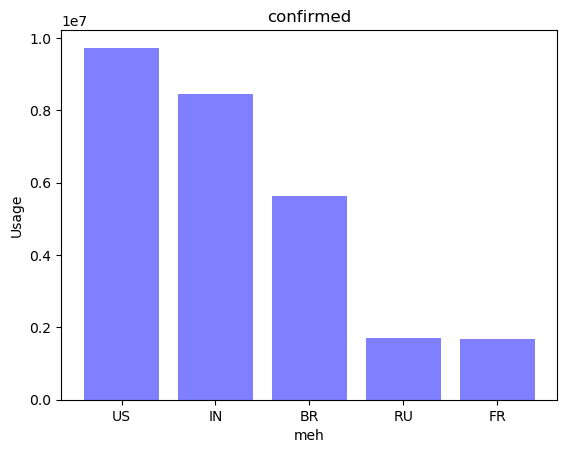

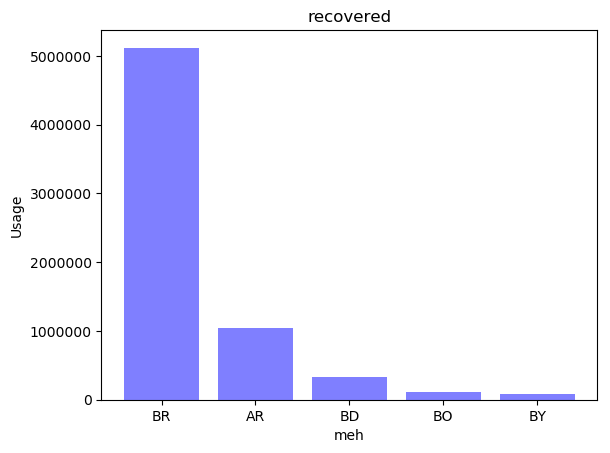

In [451]:
#plt.rcdefaults()
def bar_plot(df, sort_key, first_n):
    df_p_c = df.sort_values([sort_key], ascending=False)[:first_n]
    objects = df_p_c.country_code.tolist()
    y_pos = np.arange(len(objects))
    performance = df_p_c[sort_key].tolist()
    
    plt.bar(y_pos, performance, align='center', alpha=0.5,color='b')

    plt.xticks(y_pos, objects)
    plt.ylabel('Usage')
    plt.xlabel('meh')
    plt.title(sort_key)

    plt.show()


keys = ['deaths_percentage', 'confirmed_percentage', 'recovered_percentage', 'deaths', 'confirmed', 'recovered']
for k in keys:
    bar_plot(df_p, k, 5)

# grafico circular donde pongo total mundial de muertes / recup / confirm. 

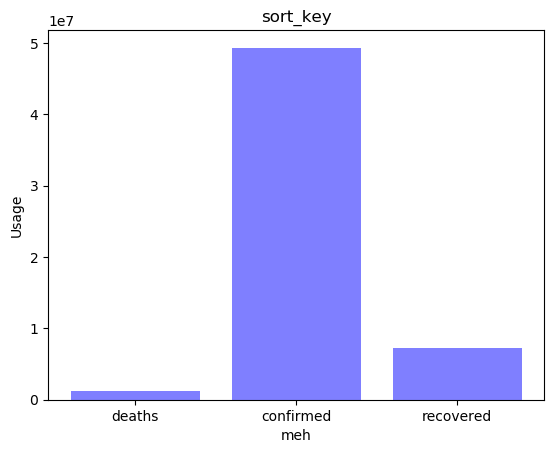

In [463]:
resp_latest = CovidAPI.get_task('/v2/latest')['latest']
objects = ['deaths', 'confirmed', 'recovered']
y_pos = np.arange(len(objects))
performance = [resp_latest['deaths'], resp_latest['confirmed'], resp_latest['recovered']]

plt.bar(y_pos, performance, align='center', alpha=0.5,color='b')

plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.xlabel('meh')
plt.title('sort_key')

plt.show()

In [464]:
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
data = pd.read_csv(url)
data.to_csv('owid-covid-data.csv')


In [469]:
url = 'https://covid.ourworldindata.org/data/owid-covid-data.json'
owid_covid_data_dict = APIHelper.get(url)

In [539]:
columns = [
"country_code",
"population",
"population_density",
"median_age",
"aged_65_older",
"aged_70_older",
"gdp_per_capita",
"cardiovasc_death_rate",
"diabetes_prevalence",
"handwashing_facilities",
"hospital_beds_per_thousand",
"life_expectancy",
"human_development_index"
]

coutries_codes_2_and_3 = pd.read_excel('Comtrade_Country_Code and_ISO_list.xlsx')

def search_iso_code_2(iso_code_3):
    i=0
    for i in range(0,len(coutries_codes_2_and_3)):
        item = coutries_codes_2_and_3.iloc[i]
        i=i+1
        try:
            if item['ISO3-digit Alpha'] == iso_code_3:
                return item['ISO2-digit Alpha']
        except:
            continue
                                          
    
df_2 = pd.DataFrame(columns=columns)

i=0
for k in owid_covid_data_dict.keys():
    values = []
    iso_code_2 = search_iso_code_2(k)
    values.append(iso_code_2)
    
    c = owid_covid_data_dict[k]
    for column_key in columns[1:]:
        try:
            values.append(c[column_key])
        except:
            values.append(None)
    
    df_2.loc[i] = values
    i=i+1

In [587]:
df_full = pd.merge(df_2, df_p, on='country_code', how='inner')
df_full.to_csv('owid-covid-data-summary.csv')

In [589]:
del df_full['deaths_percentage']
del df_full['confirmed_percentage']
del df_full['recovered_percentage']

In [590]:
for c in df_full.columns:
    if c != 'country_code':
        df_full[c] = pd.to_numeric(df_full[c])
        
df_full.dtypes

country_code                   object
population                    float64
population_density            float64
median_age                    float64
aged_65_older                 float64
aged_70_older                 float64
gdp_per_capita                float64
cardiovasc_death_rate         float64
diabetes_prevalence           float64
handwashing_facilities        float64
hospital_beds_per_thousand    float64
life_expectancy               float64
human_development_index       float64
deaths                          int64
confirmed                       int64
recovered                       int64
dtype: object

In [600]:
def get_column(A, j): 
    return A.iloc[:,j]


def scatter_list(df_corr, fixed_column, figsize):
    _, num_columns = df_corr.shape
    fig, ax = plt.subplots(1, num_columns, figsize = figsize) 
    columns = df_corr.columns.values
    ax[0].set_ylabel(fixed_column.columns.values[0], fontsize=14)
    
    for i in range(num_columns):
        
        i_column = get_column(df_corr, i)
        aux = pd.DataFrame()
        aux['A'] = i_column
        aux['B'] = fixed_column
        aux.dropna()

        ax[i].scatter(aux['A'], aux['B'], alpha=0.15, c='blue')
        ax[i].xaxis.set_visible(True) 
        ax[i].yaxis.set_visible(True)
        ax[i].set_xlabel(columns[i], fontsize=14)

    plt.show()

In [593]:
fixed_column = df_full.filter(['deaths'], axis=1)

In [594]:
df_full_ = df_full
del df_full_['deaths']
del df_full_['confirmed']
del df_full_['recovered']

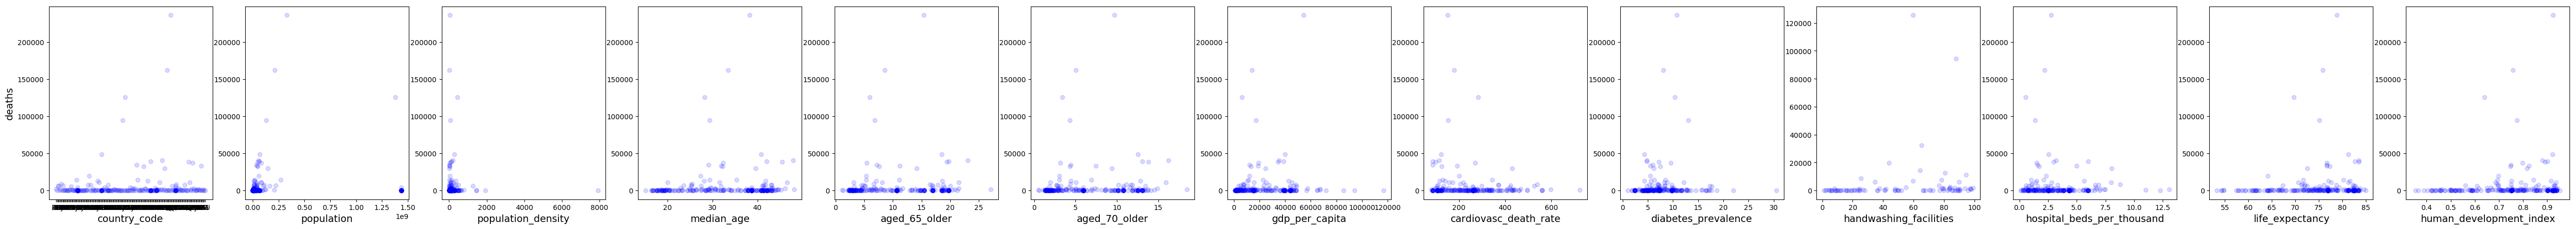

In [619]:
_, num_columns = df_full_.shape
w = 5
scatter_list(df_full_, fixed_column, figsize=(w * num_columns, w))